### **Outlier Detection with Isolation Forest in Banking and Finance**

Isolation Forest is an efficient technique for anomaly detection, particularly well-suited for multi-dimensional datasets. Developed by Liu, Ting, and Zhou in 2009, it is a variation of the Random Forest algorithm designed specifically for the task of isolating anomalous points within a dataset. 

The fundamental idea behind Isolation Forest is that anomalies are easier to isolate than normal observations. The algorithm achieves this by constructing multiple decision trees, called isolation trees, where each feature is randomly selected and partitioned at a randomly chosen threshold. This process continues recursively until each data point is isolated in a separate node.

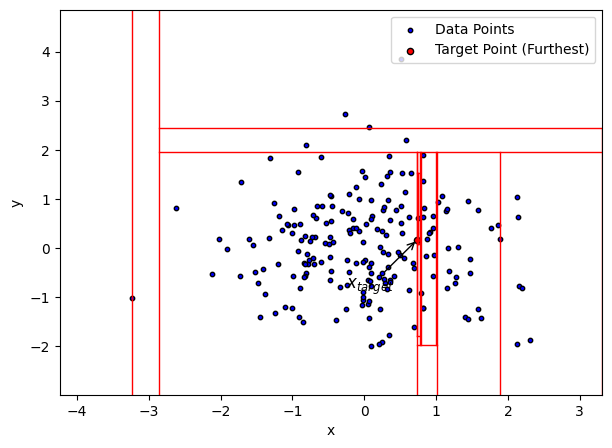

19


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate a 2D Gaussian distribution of 100 points
X = np.random.randn(200, 2)

# Automatically select the point farthest from the center (0,0)
distances = np.linalg.norm(X, axis=1)
target_idx = np.argmax(distances)
target_point = X[target_idx]

# Manually select a point as target
target_idx = 20
target_point = X[target_idx]

# Choose a point near to a specific location
#specific_point = np.array([-0.25, 2.8])
#distances      = np.linalg.norm(X - specific_point, axis=1)
#target_idx     = np.argmin(distances)
#target_point   = X[target_idx]

n_runs = 0

def isolate_point(ax, X, target_idx, bounds, depth=0, max_depth=20):
    """
    Recursively partitions the space (defined by bounds) until the only point within that region
    is the target point.
    
    Parameters:
        ax        : Matplotlib Axes object for plotting.
        X         : Full dataset (numpy array).
        target_idx: The index of the target point in X.
        bounds    : A list of tuples [(x_min, x_max), (y_min, y_max)] defining the current region.
        depth     : Current recursion depth.
        max_depth : Maximum recursion depth to prevent infinite recursion.
    """
    global n_runs
    n_runs = n_runs + 1
    # Get indices of points inside the current bounds
    in_bounds = np.where(
        (X[:, 0] >= bounds[0][0]) & (X[:, 0] <= bounds[0][1]) &
        (X[:, 1] >= bounds[1][0]) & (X[:, 1] <= bounds[1][1])
    )[0]
    
    # Stop if the region contains only the target point or if we've reached max depth.
    if len(in_bounds) == 1 and in_bounds[0] == target_idx:
        return
    if depth >= max_depth:
        return

    # Randomly choose an axis (0 for x, 1 for y) for splitting
    feature = np.random.choice([0, 1])
    current_min, current_max = bounds[feature]
    
    # Avoid degenerate bounds
    if current_min == current_max:
        return

    # Choose a random split value within the current bounds for the selected feature
    split_val = np.random.uniform(current_min, current_max)

    # Draw the partition line (constrained to the current bounds in the other dimension)
    if feature == 0:  # vertical line: x = split_val
        ax.plot([split_val, split_val], bounds[1], 'r', lw=1)
    else:             # horizontal line: y = split_val
        ax.plot(bounds[0], [split_val, split_val], 'r', lw=1)

    # Update the bounds for the region that contains the target point
    new_bounds = [list(bounds[0]), list(bounds[1])]
    target_value = X[target_idx, feature]
    if target_value < split_val:
        new_bounds[feature][1] = split_val  # update the upper bound for the chosen feature
    else:
        new_bounds[feature][0] = split_val  # update the lower bound for the chosen feature

    # Convert new_bounds back to tuples
    new_bounds = [(new_bounds[0][0], new_bounds[0][1]), (new_bounds[1][0], new_bounds[1][1])]
    
    # Recursively partition the new region
    isolate_point(ax, X, target_idx, new_bounds, depth + 1, max_depth)

# Define the initial bounds for the entire space (with some padding)
x_min, x_max = np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1
y_min, y_max = np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1
initial_bounds = [(x_min, x_max), (y_min, y_max)]

# Create a plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X[:, 0], X[:, 1], c='blue', edgecolors='k', s = 10,  label="Data Points")
ax.scatter(target_point[0], target_point[1], c='red', edgecolors='k', s=20, label="Target Point (Furthest)")

# Begin the recursive partitioning to isolate the target point
isolate_point(ax, X, target_idx, initial_bounds)

# Annotate the target point
ax.annotate(r'$x_{target}$', xy=(target_point[0], target_point[1]),
            xytext=(target_point[0]-1, target_point[1]-1),
            arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

# Set plot limits and labels
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

plt.show()
print(n_runs)


A key concept in this method is the **path length**, which represents the number of splits required to isolate a particular observation. Anomalies tend to have shorter path lengths since they are more easily separated from the rest of the data, whereas normal observations require more splits to be fully isolated. The final anomaly score for a given observation is obtained by averaging its path lengths across all trees in the forest. If an observation consistently exhibits a shorter path length across multiple trees, it is likely to be an outlier.

Once the model has been trained on a dataset without anomalies, new observations can be assessed based on how quickly they are isolated within the existing trees. Observations with shorter average path lengths are classified as anomalies, while those requiring a greater number of partitions are considered normal.

### **Implementation Example in Python**

To illustrate the functioning of Isolation Forest, a simple bi-dimensional dataset is generated, containing two well-separated clusters of normal observations. Additionally, a few anomalies are introduced to test the model’s ability to detect them. The following Python implementation demonstrates this process:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Set random seed for reproducibility
np.random.seed(42)

# Generate a 2D Gaussian distribution of 100 points
X = np.random.randn(100, 2)

# Automatically select the point farthest from the center (0,0)
distances = np.linalg.norm(X, axis=1)
target_idx = np.argmax(distances)
target_point = X[target_idx]

# Fit the Isolation Forest on the data
clf = IsolationForest(contamination=0.1, random_state=42)
clf.fit(X)

# Create a mesh grid over the feature space for visualization
x_min, x_max = np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1
y_min, y_max = np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]

# Compute the anomaly score (decision function) on the grid
Z = clf.decision_function(grid)
Z = Z.reshape(xx.shape)

# Also compute predictions (-1 for outliers, 1 for inliers) if needed:
y_pred = clf.predict(X)

# Plotting the decision function and the data points
plt.figure(figsize=(8, 6))
# Filled contour for decision function score
contour = plt.contourf(xx, yy, Z, levels=50, cmap=plt.cm.Blues_r)
plt.colorbar(contour, label="Decision Function Score")
# Draw the decision boundary (score = 0)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black', linestyles='--')

# Plot the training data
plt.scatter(X[:, 0], X[:, 1], c='blue', edgecolors='k', label="Data Points")
# Highlight the target point (the one farthest from the center)
plt.scatter(target_point[0], target_point[1], c='red', edgecolors='k',
            s=100, label="Target Point (Furthest)")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Isolation Forest Decision Function")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# --- Step 1. Generate Data and Fit Isolation Forest ---
np.random.seed(42)
X = np.random.randn(100, 2)

# Automatically select the point farthest from the center (0,0)
distances = np.linalg.norm(X, axis=1)
target_idx = np.argmax(distances)
target_point = X[target_idx]

# Fit the Isolation Forest model
clf = IsolationForest(contamination=0.1, random_state=42)
clf.fit(X)

# --- Step 2. Extract One Tree for Visualization ---
# We take the first estimator (tree) for illustration.
tree = clf.estimators_[0].tree_

# --- Step 3. Recursive Function to Plot Splitting Lines from the Tree ---
def plot_tree_splits(ax, tree, node, bounds):
    """
    Recursively plot the splitting lines for a decision tree.
    
    Parameters:
      ax     : Matplotlib Axes object for plotting.
      tree   : The tree_ attribute from a fitted Isolation Forest estimator.
      node   : Current node index.
      bounds : Current region bounds as [x_min, x_max, y_min, y_max].
    """
    # If it's a leaf node, nothing to plot.
    if tree.children_left[node] == tree.children_right[node]:
        return

    feature = tree.feature[node]
    threshold = tree.threshold[node]
    x_min, x_max, y_min, y_max = bounds

    # Depending on the feature, the split line will be vertical or horizontal.
    if feature == 0:  # split on x
        # Draw a vertical line at threshold spanning the current y-range.
        ax.plot([threshold, threshold], [y_min, y_max], 'r', lw=1)
        # Left child: x < threshold
        left_bounds = [x_min, threshold, y_min, y_max]
        # Right child: x >= threshold
        right_bounds = [threshold, x_max, y_min, y_max]
    else:  # feature == 1, split on y
        # Draw a horizontal line at threshold spanning the current x-range.
        ax.plot([x_min, x_max], [threshold, threshold], 'r', lw=1)
        # Left child: y < threshold
        left_bounds = [x_min, x_max, y_min, threshold]
        # Right child: y >= threshold
        right_bounds = [x_min, x_max, threshold, y_max]

    # Recursively plot for both children nodes
    plot_tree_splits(ax, tree, tree.children_left[node], left_bounds)
    plot_tree_splits(ax, tree, tree.children_right[node], right_bounds)

# --- Step 4. Plot Data, Decision Function, and Splitting Lines ---
# Define overall bounds (with padding)
x_min, x_max = np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1
y_min, y_max = np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:, 0], X[:, 1], c='blue', edgecolors='k', label="Data Points")
ax.scatter(target_point[0], target_point[1], c='red', edgecolors='k', s=100,
           label="Target Point (Furthest)")

# Plot the splitting lines from the first tree
plot_tree_splits(ax, tree, 0, [x_min, x_max, y_min, y_max])

# Optional: annotate the target point.
ax.annotate(r'$x_{target}$', xy=(target_point[0], target_point[1]),
            xytext=(target_point[0]-1, target_point[1]-1),
            arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.set_title("Splitting Lines from One Tree in Isolation Forest")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Set random seed for reproducibility
rng = np.random.RandomState(42)

# Generate training data: two clusters
X1_train = 0.3 * rng.randn(100, 2) - [2, 2]  
X2_train = 0.3 * rng.randn(100, 2) + [2, 2]  
X_train = np.vstack((X1_train, X2_train))  

# Generate new test data: a mix of regular points and anomalies
X_regular = 0.3 * rng.randn(50, 2) - [2, 2]  
X_regular = np.vstack((X_regular, 0.3 * rng.randn(50, 2) + [2, 2]))

X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))  
X_test = np.vstack((X_regular, X_outliers))  

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train)

# Predict new data points
y_pred_test = iso_forest.predict(X_test)

# Separate points based on prediction
regular_points = X_test[y_pred_test == 1]
outlier_points = X_test[y_pred_test == -1]

# Create a grid for decision boundary visualization
xx, yy = np.meshgrid(np.linspace(-5, 5, 300), np.linspace(-5, 5, 300))
Z = iso_forest.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot results
plt.figure(figsize=(8, 6))

# Plot decision boundary
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 10), cmap=plt.cm.Blues)

# Plot training observations
plt.scatter(X_train[:, 0], X_train[:, 1], edgecolors='k', facecolors='none', label="Training Observations")

# Plot new regular observations
plt.scatter(regular_points[:, 0], regular_points[:, 1], c='green', edgecolors='k', label="New Regular Observations")

# Plot new abnormal observations
plt.scatter(outlier_points[:, 0], outlier_points[:, 1], c='red', edgecolors='k', label="New Abnormal Observations")

plt.title("Isolation Forest")
plt.legend()
plt.show()


### **Analysis of Results**

The resulting visualization highlights three types of observations: the original training data, shown in black; new observations classified as normal, displayed in green; and anomalies, marked in red. The algorithm effectively isolates outliers due to their distinct behavior in the partitioning process. 

In the context of banking and finance, Isolation Forest has practical applications in fraud detection, financial transaction monitoring, and the identification of irregularities in market data. By leveraging its ability to distinguish between normal and anomalous patterns, financial institutions can enhance their risk assessment frameworks and improve the detection of fraudulent activities.